In [37]:
from PIL import Image
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms.functional
from torch.nn.modules.loss import _Loss
from torchvision import transforms, models, datasets
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import Sampler
from torch.autograd import Variable
import segmentation_models_pytorch as smp
import numpy as np
#import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from torchvision.models import resnet50, efficientnet_b0, inception_v3, efficientnet_b4
from torchvision.models import ResNet50_Weights
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
import seaborn as sns
import csv
import glob
import random
import copy
import pandas as pd

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [115]:
# define the device (gpu/cpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# folder path
img_dir_path = r'images'
mask_dir_path = r'cleaned_masks'

# all the paths
img_whole_paths = []
mask_whole_paths = []

# image data array
images = []

# image labels
labels = []

# seg masks
masks = []

# batch size and epochs
batch = 8
epochs = 500

# Iterate directory to store the paths
# images
for path in os.listdir(img_dir_path):
    if path[0] != '.':
        #print(path)
        img_p = os.path.join(img_dir_path, path)
        # check if current path is a file
        if os.path.isfile(img_p):
            #print(path)
            # store the path names
            img_whole_paths.append(img_p)
                
# masks
for path in os.listdir(mask_dir_path):
    if path[0] != '.':
        #print(path)
        img_p = os.path.join(mask_dir_path, path)
        # check if current path is a file
        if os.path.isfile(img_p):
            #print(path)
            # store the path names
            mask_whole_paths.append(img_p)
                
print(len(img_whole_paths))
print(len(mask_whole_paths))


cuda:0
1291
941


In [3]:
'''
for i in mask_whole_paths:
    if len(i.split(' ')) > 1:
        print(i)
'''

"\nfor i in mask_whole_paths:\n    if len(i.split(' ')) > 1:\n        print(i)\n"

In [116]:
# combine image path and mask path into one dictionary
path_combine = []

for item in img_whole_paths:
    path_dict = {}
    fn = os.path.join(mask_dir_path, os.path.basename(item))
    #print(fn)
    res = glob.glob(fn)
    #print(res)
    path_dict['img_path'] = item
    if len(res) != 0:
        path_dict['mask_path'] = res[0]
        
    path_combine.append(path_dict)

#print(path_combine)

In [117]:
# split the sets
SEED = 62
random.seed(SEED)
random.shuffle(path_combine)

train_path_combine = path_combine[:int(0.7*len(path_combine))]
test_path_combine = path_combine[int(0.7*len(path_combine)):int(0.85*len(path_combine))]
val_path_combine = path_combine[int(0.85*len(path_combine)):]

In [118]:
# =============================================================================
# Resize and Crop (use early)
# =============================================================================
class ResizeCrop(object):
    ''' Resize all to same size, then crop to get a square '''

    def __init__(self, size):
        self.resize = transforms.Resize(size=size, interpolation=transforms.InterpolationMode.NEAREST_EXACT)
        #self.centercrop = transforms.CenterCrop(size=size)

    def __call__(self, sample):
        image, mask, has_mask = sample['image'], sample['mask'], sample['has_mask']
        # also pass the size to be cropped into
        crop_size = sample['cropsize']
        
        # resize and crop to same size for image
        centercrop = transforms.CenterCrop(size=crop_size)
        image = centercrop(image)
        sample['image'] = self.resize(image)

        # for mask
        if has_mask:
            mask = centercrop(mask)
            sample['mask'] = self.resize(mask)

        return sample

# =============================================================================
# Random Horizontal Flip (use early)
# =============================================================================
class RandomHorizontalFlip(object):
    ''' Flips image and mask horizontal when random value higher than p
    '''
    def __init__(self, p=0.5):
        self.p = p
    
    def __call__(self, sample):
        image, mask, has_mask = sample['image'], sample['mask'], sample['has_mask']
        
        if random.random() < self.p:   
            image = transforms.functional.hflip(image)
            if has_mask:
                mask = transforms.functional.hflip(mask)

        sample['image'] = image
        sample['mask'] = mask
        return sample
    

# =============================================================================
# Random Vertical Flip (use early)
# =============================================================================
class RandomVerticalFlip(object):
    ''' Flips image and mask vartically when random value higher than p
    '''
    def __init__(self, p=0.5):
        self.p = p
    
    def __call__(self, sample):
        image, mask, has_mask = sample['image'], sample['mask'], sample['has_mask']
        
        if random.random() < self.p:   
            image = torchvision.transforms.functional.vflip(image)
            if has_mask:
                mask = torchvision.transforms.functional.vflip(mask)

        sample['image'] = image
        sample['mask'] = mask
        return sample
    

#
# =============================================================================
#  Normalise (use middle)
# =============================================================================
class Normalize(object):
    # used for both train and validation
    def __init__(self, mean, std):
        self.normalize = transforms.Normalize(mean, std)

    def __call__(self, sample):
        
        image = sample['image']
        sample['image'] = self.normalize(image)
        
        return sample


# =============================================================================
# ToTensor class (use last)
# =============================================================================
class ToTensor(object):
    ''' Creates a tensor from an image '''
    
    def __call__(self, sample):
        
        sample['image'] = transforms.functional.to_tensor(sample['image'])
        sample['mask'] = transforms.functional.to_tensor(sample['mask'])
            
        return sample

    
    

In [119]:
# define the customized dataset
class MyDataset(Dataset):
    """my own dataset."""

    def __init__(self, paths, mode):
        self.mode = mode
        
        # has been divided
        self.paths = paths
        
        # image size
        self.size = 288 #320  #288
        
        # define the transform
        if mode == 'train':
            self.transform = transforms.Compose([
                ToTensor(),
                ResizeCrop(self.size),
                RandomHorizontalFlip(p=0.5),
                RandomVerticalFlip(p=0.5),
                #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
        else:
            self.transform = transforms.Compose([
                ToTensor(),
                ResizeCrop(self.size),
                #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
            

            
            
        self.fake_mask = {}
                    
        self.colors = [0, 75, 149, 178, 222]
        

    def __len__(self):
        return len(self.paths)

    
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        filename = os.path.basename(self.paths[idx]['img_path'])

        im = Image.open(self.paths[idx]['img_path']).convert("RGB")
        #im.show()
        
                
        img_w, img_h= im.size  #totensor: channel, height, width
        
        crop_size = max(min(img_w, img_h) - 30, self.size)
        #crop_size = 320
        
        '''
        # Setting the points for cropped image
        img_left = 12
        img_top = 12
        img_right = img_w-12
        img_bottom = img_h-12
        im = im.crop((img_left, img_top, img_right, img_bottom))
        '''
        
        # check whether it has a mask
        if len(self.paths[idx]) > 1:
            mask = np.asarray(Image.open(self.paths[idx]['mask_path']).convert("L"))
            
            onehot_mask = np.zeros((mask.shape[0], mask.shape[1], 5))
            for i, unique_value in enumerate(self.colors):
                onehot_mask[:, :, i][mask == unique_value] = 1
            #onehot_mask = Image.fromarray(onehot_mask.astype("uint8"))
            #mask.show()
            #print('before transform',np.unique(np.array(mask)[150]))
            #print(np.array(mask))
            #mask = self.paths[idx]['mask_path'] # already a tensor, no need to transform
            
            '''            
            mask_w, mask_h = mask.size
            
            # Setting the points for cropped mask
            mask_left = 12
            mask_top = 12
            mask_right = mask_w-12
            mask_bottom = mask_h-12
            mask = mask.crop((mask_left, mask_top, mask_right, mask_bottom))         

            # error message if image and mask size dont match
            if img_w != mask_w:
                print("width mismatch! image and mask:", self.paths[idx]['img_path'], img_w, self.paths[idx]['mask_path'], mask_w, )
            if img_h != mask_h:
                print("height mismatch! image and mask:", self.paths[idx]['img_path'], img_h, self.paths[idx]['mask_path'], mask_h)
            '''
            
            has_mask = True

        else:
            # directly make up a tensor (all black)
            #mask = torch.zeros(1, self.size, self.size)
            onehot_mask = np.zeros((self.size, self.size, 5))
            onehot_mask[:, :, 0] = 1
            has_mask = False
        

        
        # store the labels
        path = os.path.basename(self.paths[idx]['img_path'])
        ori_label = int(path[0])
        

        # for training
        if ori_label > 2:
            label = 1
        else:
            label = 0
        #print(label)

        '''
        # for testing
        if ori_label not in [1]:
            label = 0
        else:
            label = 1
        #print(ori_label, label)
        '''
        
        item = {
            'image': im,
            'mask': onehot_mask,
            'label': label,
            'has_mask': has_mask,
            'filename': filename,
            'cropsize': crop_size
        }

        
        if self.transform:
            item = self.transform(item)
            
            
        #print('after transform',np.unique(item['mask']))
        
        #print(im.shape)
        #print(item['mask'])

        return item
    
    
    
    def load_gradcam_item(self, idx):
        
        im = Image.open(self.paths[idx]['img_path']).convert("RGB")
        item  = self.__getitem__(idx)
        input_tensor, label = item['image'], item['label']
        crop_size = item['cropsize']
        
        # store the filename (including .png)
        filename = os.path.basename(self.paths[idx]['img_path'])
        
        gradcam_item = {
            'image':im,
            'tensor':input_tensor,
            'label':label,
            'filename':filename,
            'cropsize': crop_size
            }
        
        return gradcam_item
    
    
    #def update_mask(self, idx):
        
        
        

    
    def index2label (self):
        has_mask_class = [] # 0: no mask; 1: has mask
        for path in self.paths:
            if len(path) > 1:
                # has mask
                has_mask_class.append(1)
            else:
                has_mask_class.append(0)
        
        return has_mask_class # which index has/doesnt have mask

In [120]:
class MixedBatchSampler(Sampler):
    def __init__(self, dataset, batch_size):

        self.batches = []
        self.label_dict = {}
        self.unique_labels = np.array([0,1])
        self.batch_size = batch_size
        self.dataset = dataset
        self.class_size = {}
        self.class_batch_size = []
        
        
        # filter out the labels
        class_distribution = self.dataset.index2label() # correspond index to class
        
        
        # for label in unique labels
        for this_label in self.unique_labels:
            # get indices of label in original labels        
            indices_list = np.squeeze(np.where(class_distribution==this_label))
            self.label_dict[this_label] = list(indices_list)
            self.class_size[this_label] = len(indices_list)
            
        # calculate the portion of each class
        class0_size = int((self.class_size[0]/len(self.dataset))*self.batch_size)
        self.class_batch_size.append(class0_size)
        self.class_batch_size.append(self.batch_size - class0_size)
        
        self.sampler_len = min(int(len(self.label_dict[0])/self.class_batch_size[0]), int(len(self.label_dict[1])/self.class_batch_size[1]))
        
        #print(self.label_dict)
        
        
        
          
    def __len__(self):                
        return self.sampler_len  #(len(self.dataset) // self.batch_size) * self.batch_size # residual just drop them
    
    
    
            
    def __iter__(self):

        # reset dataset
        self.data = copy.deepcopy(self.label_dict)

        # shuffle each class list for each iteration
        for k in self.data:
            np.random.shuffle(self.data[k])
        
        batches = []

        # for each batch
        for i in range(0, self.sampler_len): #fully divided number of batches

            batch = []
            np.random.shuffle(self.unique_labels)
            # for each unique label 
            for k in self.unique_labels:
                # if more samples than required are available
                if len(self.data[k]) >= self.class_batch_size[k]:   
                    # get the next n samples
                    batch.extend(self.data[k][:self.class_batch_size[k]])
                    # and delete them from the dataset
                    del self.data[k][:self.class_batch_size[k]]
                
            # if enough images are available for one batch: append
            if len(batch) == self.batch_size:
                #random.shuffle(batch)
                batches.append(batch)
                #print(batch)
            
        return iter(batches)

In [9]:
'''
for i in path_combine:
    im = Image.open(i['img_path']).convert("RGB")
    img_w, img_h= im.size
    im = transforms.functional.to_tensor(im)
    print(img_w, img_h)
    print(im.shape)
    break
'''

'\nfor i in path_combine:\n    im = Image.open(i[\'img_path\']).convert("RGB")\n    img_w, img_h= im.size\n    im = transforms.functional.to_tensor(im)\n    print(img_w, img_h)\n    print(im.shape)\n    break\n'

In [121]:
train_ds = MyDataset(train_path_combine, 'train')
test_ds = MyDataset(test_path_combine, 'test')
val_ds = MyDataset(val_path_combine, 'val')

#print(train_ds.__len__())
#print(val_ds.__len__())
    
mix_b_sampler = MixedBatchSampler(train_ds, batch)  # for training

train_loader = DataLoader(train_ds, batch_sampler = mix_b_sampler) # train
test_loader = DataLoader(test_ds, batch_size=batch, shuffle=False) # test
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False) # val


print("LOADERS: train, test, validation:", train_loader, test_loader, val_loader)

LOADERS: train, test, validation: <torch.utils.data.dataloader.DataLoader object at 0x0000020052C70290> <torch.utils.data.dataloader.DataLoader object at 0x0000020052C0B110> <torch.utils.data.dataloader.DataLoader object at 0x0000020052C5E250>


In [11]:
for _, item in enumerate(train_ds):
    item
    break

In [12]:
'''
for _, item in enumerate(train_ds):
    item['mask'].show()
    channel = item['mask'].convert("L")
    plt.imshow(channel)
    plt.show()
    #for i in item['mask']:
        #i.show()
        
    break
'''


'\nfor _, item in enumerate(train_ds):\n    item[\'mask\'].show()\n    channel = item[\'mask\'].convert("L")\n    plt.imshow(channel)\n    plt.show()\n    #for i in item[\'mask\']:\n        #i.show()\n        \n    break\n'

In [13]:
'''
for _, item in enumerate(train_loader):
    #print(item['mask'][0])
    for i in item['mask'][0]:
        i.show()
    break
'''

"\nfor _, item in enumerate(train_loader):\n    #print(item['mask'][0])\n    for i in item['mask'][0]:\n        i.show()\n    break\n"

In [10]:
'''
model = smp.UnetPlusPlus(
                        encoder_name="efficientnet-b0",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                        encoder_weights="imagenet",
                        in_channels=3,          # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                        classes=5,         # model output channels (number of classes in your dataset)
                        aux_params = dict(
                                        pooling="avg",
                                        dropout=0.5,
                                        classes = 2
                        )
                    )


'''
model = smp.FPN(
                        encoder_name="resnext101_32x8d",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                        encoder_weights="imagenet",
                        in_channels=3,          # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                        classes=5,         # model output channels (number of classes in your dataset)
                        aux_params = dict(
                                        pooling="avg",
                                        dropout=0.5,
                                        classes = 2
                        )
                    )

In [11]:
print(model)

FPN(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [12]:
def save_checkpoint(dir_name, epoch, f1):
    
    # If folder doesn't exists, create it #
    if not os.path.isdir(dir_name):
        os.mkdir(dir_name)
        
    filename = "checkpoint-{:.3f}-{}.pth".format(f1, epoch)
    whole_name = os.path.join(dir_name, filename)
    torch.save(model.state_dict(), whole_name)

In [13]:
def soft_dice_score(
    output: torch.Tensor,
    target: torch.Tensor,
    smooth: float = 0.0,
    eps: float = 1e-7,
    dims=None,
) -> torch.Tensor:
    assert output.size() == target.size()
    if dims is not None:
        intersection = torch.sum(output * target, dim=dims)
        cardinality = torch.sum(output + target, dim=dims)
    else:
        intersection = torch.sum(output * target)
        cardinality = torch.sum(output + target)
    dice_score = (2.0 * intersection + smooth) / (cardinality + smooth).clamp_min(eps)
    return dice_score

In [14]:
class DiceLoss(_Loss):
    def __init__(
        self,
        #mode: str,
        #classes: Optional[List[int]] = None,
        log_loss: bool = False,
        from_logits: bool = True,
        smooth: float = 0.0,
        #ignore_index: Optional[int] = None,
        eps: float = 1e-7,
    ):
        """Dice loss for image segmentation task.
        It supports binary, multiclass and multilabel cases

        Args:
            mode: Loss mode 'binary', 'multiclass' or 'multilabel'
            classes:  List of classes that contribute in loss computation. By default, all channels are included.
            log_loss: If True, loss computed as `- log(dice_coeff)`, otherwise `1 - dice_coeff`
            from_logits: If True, assumes input is raw logits
            smooth: Smoothness constant for dice coefficient (a)
            ignore_index: Label that indicates ignored pixels (does not contribute to loss)
            eps: A small epsilon for numerical stability to avoid zero division error
                (denominator will be always greater or equal to eps)

        Shape
             - **y_pred** - torch.Tensor of shape (N, C, H, W)
             - **y_true** - torch.Tensor of shape (N, H, W) or (N, C, H, W)

        Reference
            https://github.com/BloodAxe/pytorch-toolbelt
        """
        #assert mode in {BINARY_MODE, MULTILABEL_MODE, MULTICLASS_MODE}  # only keep those required in multiclass
        super(DiceLoss, self).__init__()
        #self.mode = mode
        #if classes is not None:
            #assert mode != BINARY_MODE, "Masking classes is not supported with mode=binary"
            #classes = to_tensor(classes, dtype=torch.long)

        #self.classes = classes
        self.from_logits = from_logits
        self.smooth = smooth
        self.eps = eps
        self.log_loss = log_loss
        #self.ignore_index = ignore_index

    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:

        assert y_true.size(0) == y_pred.size(0)

        if self.from_logits:
            # Apply activations to get [0..1] class probabilities
            # Using Log-Exp as this gives more numerically stable result and does not cause vanishing gradient on
            # extreme values 0 and 1
            #if self.mode == MULTICLASS_MODE:
            y_pred = y_pred.log_softmax(dim=1).exp()
            #else:
                #y_pred = F.logsigmoid(y_pred).exp()
                
        #print('true:', np.unique(y_true[0].detach().cpu().numpy()))

        bs = y_true.size(0)
        num_classes = y_pred.size(1)
        dims = (0, 2)

        '''        
        if self.mode == BINARY_MODE:
            y_true = y_true.view(bs, 1, -1)
            y_pred = y_pred.view(bs, 1, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask
        '''
        
        #if self.mode == MULTICLASS_MODE:
        y_true = y_true.view(bs, num_classes, -1)
        y_pred = y_pred.view(bs, num_classes, -1)

        '''
        if self.ignore_index is not None:
            mask = y_true != self.ignore_index
            y_pred = y_pred * mask.unsqueeze(1)

            y_true = F.one_hot((y_true * mask).to(torch.long), num_classes)  # N,H*W -> N,H*W, C
            y_true = y_true.permute(0, 2, 1) * mask.unsqueeze(1)  # N, C, H*W
        else:
        '''
        #print('true:', np.unique(y_true[0].detach().cpu().numpy()))
        #y_true = nn.functional.one_hot(y_true, num_classes)  # N,H*W -> N,H*W, C
        #y_true = y_true.permute(0, 2, 1)  # N, C, H*W
        
       
        '''         
        if self.mode == MULTILABEL_MODE:
            y_true = y_true.view(bs, num_classes, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask
         '''

        #print('pred:', y_pred[0].detach().cpu().numpy())
        #print('true:', sum(y_true[0][1].detach().cpu().numpy()))
        scores = self.compute_score(y_pred, y_true.type_as(y_pred), smooth=self.smooth, eps=self.eps, dims=dims)

        if self.log_loss:
            loss = -torch.log(scores.clamp_min(self.eps))
        else:
            loss = 1.0 - scores

        # Dice loss is undefined for non-empty classes
        # So we zero contribution of channel that does not have true pixels
        # NOTE: A better workaround would be to use loss term `mean(y_pred)`
        # for this case, however it will be a modified jaccard loss

        mask = y_true.sum(dims) > 0
        loss *= mask.to(loss.dtype)

        #if self.classes is not None:
        #    loss = loss[self.classes]

        return self.aggregate_loss(loss)

    def aggregate_loss(self, loss):
        return loss.mean()

    def compute_score(self, output, target, smooth=0.0, eps=1e-7, dims=None) -> torch.Tensor:
        return soft_dice_score(output, target, smooth, eps, dims)

In [15]:
class LovaszLoss(_Loss):
    def __init__(self, classes='present', per_image=False, ignore=None):
        """
        Multi-class Lovasz-Softmax loss
          classes: 'all' for all, 'present' for classes present in labels, or a list of classes to average.
          per_image: compute the loss per image instead of per batch
          ignore: void class labels
        """
        super(LovaszLoss, self).__init__()
        
        self.classes = classes
        self.per_image = per_image
        self.ignore = ignore
        
        
    def forward(self, preds, labels):
        """
        Multi-class Lovasz-Softmax loss
          probas: [B, C, H, W] Variable, class probabilities at each prediction (between 0 and 1).
                  Interpreted as binary (sigmoid) output with outputs of size [B, H, W].
          labels: [B, H, W] Tensor, ground truth labels (between 0 and C - 1)
        """

        probas = nn.functional.softmax(preds, dim=1) # use softmax to convert predictions to probability form
        labels = torch.argmax(labels, dim=1) # original labels [B, C, H, W] -> use argmax to convert it to [B, H, W]
        #print(probas.shape)
        #print(labels.shape)

        if self.per_image:
            loss = self.mean(self.lovasz_softmax_flat(*self.flatten_probas(prob.unsqueeze(0), lab.unsqueeze(0), self.ignore), classes=self.classes)
                              for prob, lab in zip(probas, labels))
        else:
            loss = self.lovasz_softmax_flat(*self.flatten_probas(probas, labels, self.ignore), classes=self.classes)
        return loss

    
    
    def lovasz_grad(self, gt_sorted):
        """
        Computes gradient of the Lovasz extension w.r.t sorted errors
        See Alg. 1 in paper
        """
        p = len(gt_sorted)
        gts = gt_sorted.sum()
        intersection = gts - gt_sorted.float().cumsum(0)
        union = gts + (1 - gt_sorted).float().cumsum(0)
        jaccard = 1. - intersection / union
        if p > 1: # cover 1-pixel case
            jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
        return jaccard
    
    

    def lovasz_softmax_flat(self, probas, labels, classes='present'):
        """
        Multi-class Lovasz-Softmax loss
          probas: [P, C] Variable, class probabilities at each prediction (between 0 and 1)
          labels: [P] Tensor, ground truth labels (between 0 and C - 1)
          classes: 'all' for all, 'present' for classes present in labels, or a list of classes to average.
        """
        if probas.numel() == 0:
            # only void pixels, the gradients should be 0
            return probas * 0.
        C = probas.size(1)
        losses = []
        class_to_sum = list(range(C)) if classes in ['all', 'present'] else classes
        for c in class_to_sum:
            fg = (labels == c).float() # foreground for class c
            if (classes == 'present' and fg.sum() == 0):
                continue
            if C == 1:
                if len(classes) > 1:
                    raise ValueError('Sigmoid output possible only with 1 class')
                class_pred = probas[:, 0]
            else:
                class_pred = probas[:, c]
            errors = (Variable(fg) - class_pred).abs()
            errors_sorted, perm = torch.sort(errors, 0, descending=True)
            perm = perm.data
            fg_sorted = fg[perm]
            losses.append(torch.dot(errors_sorted, Variable(self.lovasz_grad(fg_sorted))))
        return self.mean(losses)


    
    def flatten_probas(self, probas, labels, ignore=None):
        """
        Flattens predictions in the batch
        """
        if probas.dim() == 3:
            # assumes output of a sigmoid layer
            B, H, W = probas.size()
            probas = probas.view(B, 1, H, W)
        B, C, H, W = probas.size()
        probas = probas.permute(0, 2, 3, 1).contiguous().view(-1, C)  # B * H * W, C = P, C
        labels = labels.view(-1)
        if ignore == None:
            return probas, labels
        valid = (labels != ignore)
        vprobas = probas[valid.nonzero().squeeze()]
        vlabels = labels[valid]
        return vprobas, vlabels

    
    
    def xloss(self, logits, labels, ignore=None):
        """
        Cross entropy loss
        """
        return nn.functional.cross_entropy(logits, Variable(labels), ignore_index=255)
    
    
    # helper functions below
    
    def isnan(self, x):
        return x != x


    def mean(self, l, ignore_nan=False, empty=0):
        """
        nanmean compatible with generators.
        """
        l = iter(l)
        if ignore_nan:
            l = ifilterfalse(self.isnan, l)
        try:
            n = 1
            acc = next(l)
        except StopIteration:
            if empty == 'raise':
                raise ValueError('Empty mean')
            return empty
        for n, v in enumerate(l, 2):
            acc += v
        if n == 1:
            return acc
        return acc / n
    

In [16]:
class_weight_s = torch.tensor([0.1, 0.7, 0.6, 0.5, 1]).to(device)
class_weight_c = torch.tensor([0.37, 0.63]).to(device)

In [17]:
criterions = {'s_ce': nn.CrossEntropyLoss(weight = class_weight_s), 
              'c_ce': nn.CrossEntropyLoss(weight = class_weight_c), 
              'dice': DiceLoss(smooth=1, from_logits=True), 
              'lovasz': LovaszLoss()} #

In [18]:
def lambda_func(current_ep, bound, alpha):
    # set total to 40 epochs
    center = bound / 2
    if current_ep < bound:
        return 1.0 / (1.0 + np.exp(alpha*(current_ep-center)))
    else:
        return 1.0 / (1.0 + np.exp(alpha*(bound-center)))

In [23]:
def train_model(train_data, val_data, model, epochs, dir_name):
    
    model = model.to(device)
    # define the optimization
    # Observe that all parameters are being optimized
    optimizers = {'sgd': optim.SGD(model.parameters(), lr=0.001), 'adam': optim.Adam(model.parameters(), lr=0.0001)}
    # Decay LR by a factor of 0.1 every 7 epochs
    lrsdls = {'sgd': torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizers['sgd'], T_0 = 250, eta_min = 0.00001), 
             'adam': torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizers['adam'], T_0 = 100, eta_min = 0.000001)}
    #exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    train_dataset_size = len(train_data.dataset)
    val_dataset_size = len(val_data.dataset)
    #print(dataset_size)
    #print(val_dataset_size)
    
    # default
    classification_loss_fn = criterions['c_ce']
    segmentation_loss_fn_ce = criterions['s_ce']
    segmentation_loss_fn_dice = criterions['dice']
    segmentation_loss_fn_lovasz = criterions['lovasz']
    optimizer_ft = optimizers['sgd']
    lrsdl = lrsdls['sgd']
    
    
    # store the accuracy and loss
    train_losses = []
    train_accs = []
    train_f1s = []
    train_recalls = []
    train_precisions = []
    val_losses = []
    val_accs = []
    val_f1s = []
    val_recalls = []
    val_precisions = []
    
    update = -1 # -1: not started; and then everytime make it %5
    
    
    f1_improve = 0
    

    # enumerate epochs
    for epoch in range(epochs):
    #for epoch in range(5):
        
        # choose the criterion
        #if epoch >= 30:
            #if epoch%20 == 0:
                #criterion = criterions['ce']
            #elif epoch%10 == 0:
                #criterion = criterions['cdw']
            #optimizer_ft = optimizers['adam']
            #lrsdl = lrsdls['adam']
        
        # record the labels and predictions of each epoch
        train_preds = []
        train_labels = []
        val_preds = []
        val_labels = []
        
        running_loss = []
        running_class_loss = []
        running_seg_loss = []
        running_corrects = 0
        model.train()
        
        # adjust the weight between 2 losses
        bound = 40
        alpha = 0.25
        
        # when reaching certain epoch, add the predicted mask into mask (and update every 5 epochs)
        #if epoch > 0.6*epochs:
            #update += 1
        
        # enumerate mini batches
        for item in tqdm(train_data):
            
            train_labels.extend(item['label'].numpy())
            
            # pass the data to the device
            inputs = item['image'].to(device)
            targets = item['label'].to(device)
            masks = item['mask'].to(device)
            
            #print('mask:', np.unique(item['mask'][0]))
            
            # unlabelled
            unlabelled_batch_ids = np.where(item["has_mask"] == False) 
            # labelled
            labelled_batch_ids = np.where(item["has_mask"] == True) 
            
            # clear the gradients
            optimizer_ft.zero_grad()
            
            # compute the model output
            output_masks, output_labels = model(inputs) # predicted mask and label
            
            '''
            _, output_toprint = torch.max(output_masks, 1)
            #_, truth_toprint = torch.max(masks, 1)
            output_toprint = output_toprint.detach().cpu().numpy()
            #print('output mask', output_masks[0].detach().cpu().numpy())
            plt.imshow(output_toprint[0])
            #print('true mask', truth_toprint)
            #plt.imshow(output_masks[0].squeeze().detach().cpu().numpy().round())
            '''
            
            # update the masks
            #if epoch > 0.6*epochs:
                
            
            # filter out those with masks to compute loss
            labelled_mask = masks[labelled_batch_ids].to(device)
            labelled_outmask = output_masks[labelled_batch_ids].float().to(device)
            #print(labelled_mask.shape, labelled_outmask.shape)
            
            #print("train", outputs)
            _, label_preds = torch.max(output_labels, 1) #actual prediction
            train_preds.extend(label_preds.detach().cpu().numpy())
            
            # calculate loss
            train_classification_loss = classification_loss_fn(output_labels, targets)
            train_segmentation_loss_ce = segmentation_loss_fn_ce(labelled_outmask, labelled_mask)
            train_segmentation_loss_dice = segmentation_loss_fn_dice(labelled_outmask, labelled_mask)
            #train_segmentation_loss_lovasz = segmentation_loss_fn_lovasz(labelled_outmask, labelled_mask)
            train_segmentation_loss = train_segmentation_loss_ce + train_segmentation_loss_dice
            #train_segmentation_loss = train_segmentation_loss_ce + train_segmentation_loss_lovasz
            #print('segmentation loss:', train_segmentation_loss)
            # credit assignment
            if epoch < 20:
                train_combined_loss = train_classification_loss + train_segmentation_loss
                train_segmentation_loss.backward()
            else:
                lmda = lambda_func(epoch, bound, alpha)
                train_combined_loss = train_classification_loss + lmda * train_segmentation_loss
                train_combined_loss.backward()
            # update model weights
            optimizer_ft.step()
            lrsdl.step()
            
            # statistics
            running_class_loss.append(train_classification_loss.detach().cpu().numpy()) # loss for classification
            running_seg_loss.append(train_segmentation_loss.detach().cpu().numpy()) # loss for segmentation
            running_loss.append(train_combined_loss.detach().cpu().numpy()) # loss for above two
            running_corrects += torch.sum(label_preds == targets.data)  # for classification
            
        epoch_loss = np.mean(running_loss) # loss for all
        epoch_seg_loss = np.mean(running_seg_loss) # for segmentation
        epoch_class_loss = np.mean(running_class_loss) # for classification
        epoch_acc = running_corrects / train_dataset_size # for classification
        epoch_acc = epoch_acc.cpu()
        
        train_losses.append(epoch_class_loss)
        train_accs.append(epoch_acc)
        
        #print(train_labels)
        #print(train_preds)
        
        # for classification task
        train_f1 = f1_score(train_labels, train_preds, average='macro')
        train_recall = recall_score(train_labels, train_preds, average='macro')
        train_precision = precision_score(train_labels, train_preds, average='macro')
        
        train_f1s.append(train_f1)
        train_recalls.append(train_recall)
        train_precisions.append(train_precision)

        print('Epoch {} | Training Loss: total-{:.4f} classification-{:.4f} segmentation-{:.4f} | Acc: {:.4f} | F1: {:.4f} | Recall: {:.4f} | Precision: {:.4f}'.format(epoch+1, epoch_loss, epoch_class_loss, epoch_seg_loss, epoch_acc, train_f1, train_recall, train_precision))
        
        # validation
        model.eval()
        with torch.no_grad():
            val_running_loss = []
            val_running_seg_loss = []
            val_running_class_loss = []
            val_running_corrects = 0
            for item in tqdm(val_data):
                
                val_labels.extend(item['label'].numpy())
                
                # pass the data to the device
                val_inputs = item['image'].to(device)
                val_targets = item['label'].to(device)
                val_masks = item['mask'].to(device)
                                  
                # unlabelled
                unlabelled_batch_ids = np.where(item["has_mask"] == False) 
                # labelled
                labelled_batch_ids = np.where(item["has_mask"] == True) 
                
                # output of the model (segmentation and classification)
                val_output_masks, val_output_labels = model(val_inputs) # predicted mask and label
                #print("val:", val_output_masks, val_output_labels)
                                  
                # filter out those with masks to compute loss
                labelled_mask = val_masks[labelled_batch_ids].to(device)
                labelled_outmask = val_output_masks[labelled_batch_ids].float().to(device)                
                
                # calculate loss
                val_classification_loss = classification_loss_fn(val_output_labels, val_targets)
                #labelled_mask = labelled_mask.squeeze(1)
                if len(labelled_mask) > 0:
                    val_segmentation_loss_ce = segmentation_loss_fn_ce(labelled_outmask, labelled_mask)
                    val_segmentation_loss_dice = segmentation_loss_fn_dice(labelled_outmask, labelled_mask)
                    #val_segmentation_loss_lovasz = segmentation_loss_fn_lovasz(labelled_outmask, labelled_mask)
                    val_segmentation_loss = val_segmentation_loss_ce + val_segmentation_loss_dice
                    #val_segmentation_loss = val_segmentation_loss_ce + val_segmentation_loss_lovasz
                    #val_combined_loss = val_classification_loss + val_segmentation_loss
                #else:
                    #val_combined_loss = val_classification_loss
                
                _, val_label_pred = torch.max(val_output_labels, 1)
                val_preds.extend(val_label_pred.detach().cpu().numpy())
                                  
                # statistics
                val_running_class_loss.append(val_classification_loss.detach().cpu().numpy())
                if len(labelled_mask) > 0:
                    val_running_seg_loss.append(val_segmentation_loss.detach().cpu().numpy())
                else:
                    val_running_seg_loss.append(0)
                #val_running_loss.append(val_combined_loss.detach().cpu().numpy())
                val_running_corrects += torch.sum(val_label_pred == val_targets.data)
            
                                  
            #val_epoch_loss = np.mean(val_running_loss)
            val_epoch_seg_loss = np.mean(val_running_seg_loss)
            val_epoch_class_loss = np.mean(val_running_class_loss)
            val_epoch_acc = val_running_corrects / val_dataset_size    
            val_epoch_acc = val_epoch_acc.cpu()
            
            val_losses.append(val_epoch_class_loss)
            val_accs.append(val_epoch_acc)
            
            
            val_f1 = f1_score(val_labels, val_preds, average='macro')
            val_recall = recall_score(val_labels, val_preds, average='macro')
            val_precision = precision_score(val_labels, val_preds, average='macro')
            
            val_f1s.append(val_f1)
            val_recalls.append(val_recall)
            val_precisions.append(val_precision)
            
            print('Epoch {} | Validation Loss: classification-{:.4f} segmentation-{:.4f} | Acc: {:.4f} | F1: {:.4f}|  Recall: {:.4f} | Precision: {:.4f}'.format(epoch+1, val_epoch_class_loss, val_epoch_seg_loss, val_epoch_acc, val_f1, val_recall, val_precision))
            #print('segmentation loss:', val_epoch_seg_loss)
                
            
            if val_f1 > 0.9:
                f1_improve += 1
                if val_f1 == max(val_f1s) and val_f1 > max(val_f1s[:-1]):
                    save_checkpoint(dir_name, epoch+1, val_f1)
                    f1_improve = 0
                if f1_improve > 25:
                    print('Epoch {} early stopping'.format(epoch+1))
                    break
            
            
            
    # plot
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label="Validation")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title("Loss Graph")
    plt.show()
    
    plt.plot(train_accs, label='Train')
    plt.plot(val_accs, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Graph')
    plt.show()
    
    plt.plot(train_f1s, label='Train')
    plt.plot(val_f1s, label="Validation")
    plt.xlabel('Epochs')
    plt.ylabel('Macro F1')
    plt.title("Macro-F1 Graph")
    plt.show()
    
    plt.plot(train_recalls, label='Train')
    plt.plot(val_recalls, label="Validation")
    plt.xlabel('Epochs')
    plt.ylabel('Macro Recall')
    plt.title("Macro-Recall Graph")
    plt.show()
    
    plt.plot(train_precisions, label='Train')
    plt.plot(val_precisions, label="Validation")
    plt.xlabel('Epochs')
    plt.ylabel('Macro Precision')
    plt.title("Macro-Precision Graph")
    plt.show()
    
    # confusion matrix of the last time
    val_cfmtx = confusion_matrix(val_labels, val_preds)
    #print(val_cfmtx.type)
    val_cfmtxn = val_cfmtx.astype('float') / val_cfmtx.sum(axis=1)[:, np.newaxis]
    sns.heatmap(val_cfmtxn, annot=True, fmt='.2%', cmap='Blues')

100%|██████████| 111/111 [01:09<00:00,  1.59it/s]


Epoch 1 | Training Loss: total-1.7786 classification-0.8112 segmentation-0.9674 | Acc: 0.4817 | F1: 0.4667 | Recall: 0.5152 | Precision: 0.5114


100%|██████████| 25/25 [00:07<00:00,  3.23it/s]


Epoch 1 | Validation Loss: classification-0.7372 segmentation-0.8538 | Acc: 0.4948 | F1: 0.4856|  Recall: 0.5376 | Precision: 0.5314


100%|██████████| 111/111 [01:13<00:00,  1.51it/s]


Epoch 2 | Training Loss: total-1.6313 classification-0.7737 segmentation-0.8576 | Acc: 0.5426 | F1: 0.5208 | Recall: 0.5670 | Precision: 0.5501


100%|██████████| 25/25 [00:08<00:00,  3.03it/s]


Epoch 2 | Validation Loss: classification-0.7311 segmentation-0.8309 | Acc: 0.4794 | F1: 0.4575|  Recall: 0.4829 | Precision: 0.4861


100%|██████████| 111/111 [01:16<00:00,  1.45it/s]


Epoch 3 | Training Loss: total-1.6564 classification-0.8256 segmentation-0.8308 | Acc: 0.4718 | F1: 0.4564 | Recall: 0.5024 | Precision: 0.5018


100%|██████████| 25/25 [00:08<00:00,  3.06it/s]


Epoch 3 | Validation Loss: classification-0.7333 segmentation-0.7797 | Acc: 0.4639 | F1: 0.4489|  Recall: 0.4831 | Precision: 0.4861


100%|██████████| 111/111 [01:16<00:00,  1.46it/s]


Epoch 4 | Training Loss: total-1.5801 classification-0.8130 segmentation-0.7670 | Acc: 0.5105 | F1: 0.4892 | Recall: 0.5317 | Precision: 0.5237


100%|██████████| 25/25 [00:08<00:00,  2.95it/s]


Epoch 4 | Validation Loss: classification-0.7307 segmentation-0.7564 | Acc: 0.4433 | F1: 0.4159|  Recall: 0.4302 | Precision: 0.4433


100%|██████████| 111/111 [01:15<00:00,  1.46it/s]


Epoch 5 | Training Loss: total-1.5848 classification-0.8202 segmentation-0.7646 | Acc: 0.4718 | F1: 0.4495 | Recall: 0.4842 | Precision: 0.4882


100%|██████████| 25/25 [00:08<00:00,  3.02it/s]


Epoch 5 | Validation Loss: classification-0.7306 segmentation-0.7385 | Acc: 0.4639 | F1: 0.4290|  Recall: 0.4391 | Precision: 0.4503


100%|██████████| 111/111 [01:16<00:00,  1.45it/s]


Epoch 6 | Training Loss: total-1.5316 classification-0.7943 segmentation-0.7374 | Acc: 0.5039 | F1: 0.4844 | Recall: 0.5287 | Precision: 0.5215


100%|██████████| 25/25 [00:08<00:00,  3.03it/s]


Epoch 6 | Validation Loss: classification-0.7370 segmentation-0.7277 | Acc: 0.4485 | F1: 0.4391|  Recall: 0.4833 | Precision: 0.4860


100%|██████████| 111/111 [01:15<00:00,  1.47it/s]


Epoch 7 | Training Loss: total-1.5511 classification-0.8260 segmentation-0.7251 | Acc: 0.4640 | F1: 0.4520 | Recall: 0.5032 | Precision: 0.5024


100%|██████████| 25/25 [00:08<00:00,  3.05it/s]


Epoch 7 | Validation Loss: classification-0.7319 segmentation-0.7188 | Acc: 0.4639 | F1: 0.4469|  Recall: 0.4776 | Precision: 0.4816


100%|██████████| 111/111 [01:16<00:00,  1.46it/s]


Epoch 8 | Training Loss: total-1.5047 classification-0.7941 segmentation-0.7107 | Acc: 0.5072 | F1: 0.4859 | Recall: 0.5279 | Precision: 0.5209


100%|██████████| 25/25 [00:07<00:00,  3.16it/s]


Epoch 8 | Validation Loss: classification-0.7318 segmentation-0.7090 | Acc: 0.4588 | F1: 0.4250|  Recall: 0.4355 | Precision: 0.4475


100%|██████████| 111/111 [01:16<00:00,  1.45it/s]


Epoch 9 | Training Loss: total-1.5168 classification-0.8205 segmentation-0.6962 | Acc: 0.4529 | F1: 0.4308 | Recall: 0.4624 | Precision: 0.4718


100%|██████████| 25/25 [00:08<00:00,  3.02it/s]


Epoch 9 | Validation Loss: classification-0.7246 segmentation-0.7070 | Acc: 0.4639 | F1: 0.4290|  Recall: 0.4391 | Precision: 0.4503


100%|██████████| 111/111 [01:15<00:00,  1.46it/s]


Epoch 10 | Training Loss: total-1.4925 classification-0.8007 segmentation-0.6918 | Acc: 0.5039 | F1: 0.4776 | Recall: 0.5120 | Precision: 0.5090


100%|██████████| 25/25 [00:08<00:00,  3.07it/s]


Epoch 10 | Validation Loss: classification-0.7334 segmentation-0.6974 | Acc: 0.4845 | F1: 0.4592|  Recall: 0.4810 | Precision: 0.4845


100%|██████████| 111/111 [01:16<00:00,  1.46it/s]


Epoch 11 | Training Loss: total-1.4745 classification-0.8069 segmentation-0.6676 | Acc: 0.4906 | F1: 0.4683 | Recall: 0.5061 | Precision: 0.5045


100%|██████████| 25/25 [00:08<00:00,  3.04it/s]


Epoch 11 | Validation Loss: classification-0.7234 segmentation-0.6964 | Acc: 0.4794 | F1: 0.4550|  Recall: 0.4774 | Precision: 0.4816


100%|██████████| 111/111 [01:17<00:00,  1.43it/s]


Epoch 12 | Training Loss: total-1.4608 classification-0.8020 segmentation-0.6588 | Acc: 0.4828 | F1: 0.4666 | Recall: 0.5129 | Precision: 0.5097


100%|██████████| 25/25 [00:07<00:00,  3.17it/s]


Epoch 12 | Validation Loss: classification-0.7148 segmentation-0.6821 | Acc: 0.5052 | F1: 0.4783|  Recall: 0.5009 | Precision: 0.5007


100%|██████████| 111/111 [01:14<00:00,  1.48it/s]


Epoch 13 | Training Loss: total-1.4627 classification-0.8107 segmentation-0.6520 | Acc: 0.4806 | F1: 0.4631 | Recall: 0.5069 | Precision: 0.5052


100%|██████████| 25/25 [00:07<00:00,  3.16it/s]


Epoch 13 | Validation Loss: classification-0.7126 segmentation-0.6838 | Acc: 0.5412 | F1: 0.4979|  Recall: 0.5095 | Precision: 0.5079


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch 14 | Training Loss: total-1.4472 classification-0.8023 segmentation-0.6449 | Acc: 0.5017 | F1: 0.4874 | Recall: 0.5408 | Precision: 0.5307


100%|██████████| 25/25 [00:08<00:00,  2.99it/s]


Epoch 14 | Validation Loss: classification-0.7274 segmentation-0.6765 | Acc: 0.4948 | F1: 0.4747|  Recall: 0.5046 | Precision: 0.5038


100%|██████████| 111/111 [01:15<00:00,  1.48it/s]


Epoch 15 | Training Loss: total-1.4480 classification-0.8112 segmentation-0.6367 | Acc: 0.4773 | F1: 0.4625 | Recall: 0.5107 | Precision: 0.5080


100%|██████████| 25/25 [00:08<00:00,  3.10it/s]


Epoch 15 | Validation Loss: classification-0.7245 segmentation-0.6760 | Acc: 0.5155 | F1: 0.4810|  Recall: 0.4971 | Precision: 0.4976


100%|██████████| 111/111 [01:15<00:00,  1.47it/s]


Epoch 16 | Training Loss: total-1.4473 classification-0.8125 segmentation-0.6347 | Acc: 0.5017 | F1: 0.4820 | Recall: 0.5257 | Precision: 0.5192


100%|██████████| 25/25 [00:08<00:00,  3.04it/s]


Epoch 16 | Validation Loss: classification-0.7287 segmentation-0.6758 | Acc: 0.5103 | F1: 0.4640|  Recall: 0.4715 | Precision: 0.4763


100%|██████████| 111/111 [01:15<00:00,  1.47it/s]


Epoch 17 | Training Loss: total-1.4165 classification-0.7943 segmentation-0.6222 | Acc: 0.4961 | F1: 0.4715 | Recall: 0.5068 | Precision: 0.5051


100%|██████████| 25/25 [00:07<00:00,  3.17it/s]


Epoch 17 | Validation Loss: classification-0.7128 segmentation-0.6622 | Acc: 0.5052 | F1: 0.4668|  Recall: 0.4789 | Precision: 0.4827


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


Epoch 18 | Training Loss: total-1.4079 classification-0.7863 segmentation-0.6216 | Acc: 0.5039 | F1: 0.4855 | Recall: 0.5317 | Precision: 0.5237


100%|██████████| 25/25 [00:07<00:00,  3.13it/s]


Epoch 18 | Validation Loss: classification-0.7206 segmentation-0.6615 | Acc: 0.5052 | F1: 0.4729|  Recall: 0.4899 | Precision: 0.4917


100%|██████████| 111/111 [01:15<00:00,  1.47it/s]


Epoch 19 | Training Loss: total-1.3949 classification-0.7755 segmentation-0.6193 | Acc: 0.5172 | F1: 0.4875 | Recall: 0.5195 | Precision: 0.5146


100%|██████████| 25/25 [00:08<00:00,  3.05it/s]


Epoch 19 | Validation Loss: classification-0.7155 segmentation-0.6540 | Acc: 0.4948 | F1: 0.4700|  Recall: 0.4937 | Precision: 0.4948


100%|██████████| 111/111 [01:15<00:00,  1.47it/s]


Epoch 20 | Training Loss: total-1.3931 classification-0.7813 segmentation-0.6117 | Acc: 0.4784 | F1: 0.4618 | Recall: 0.5069 | Precision: 0.5052


100%|██████████| 25/25 [00:08<00:00,  3.08it/s]


Epoch 20 | Validation Loss: classification-0.7204 segmentation-0.6512 | Acc: 0.5103 | F1: 0.4825|  Recall: 0.5044 | Precision: 0.5036


100%|██████████| 111/111 [01:16<00:00,  1.46it/s]


Epoch 21 | Training Loss: total-0.8797 classification-0.5758 segmentation-0.6078 | Acc: 0.6955 | F1: 0.6345 | Recall: 0.6463 | Precision: 0.6289


100%|██████████| 25/25 [00:08<00:00,  3.11it/s]


Epoch 21 | Validation Loss: classification-0.3773 segmentation-0.6459 | Acc: 0.9021 | F1: 0.8849|  Recall: 0.9042 | Precision: 0.8714


100%|██████████| 111/111 [01:16<00:00,  1.45it/s]


Epoch 22 | Training Loss: total-0.5900 classification-0.3203 segmentation-0.6160 | Acc: 0.8649 | F1: 0.8454 | Recall: 0.8608 | Precision: 0.8334


100%|██████████| 25/25 [00:08<00:00,  3.07it/s]


Epoch 22 | Validation Loss: classification-0.2232 segmentation-0.6466 | Acc: 0.9433 | F1: 0.9320|  Recall: 0.9440 | Precision: 0.9221


100%|██████████| 111/111 [01:16<00:00,  1.46it/s]


Epoch 23 | Training Loss: total-0.4350 classification-0.2025 segmentation-0.6159 | Acc: 0.9114 | F1: 0.9045 | Recall: 0.9150 | Precision: 0.8954


100%|██████████| 25/25 [00:08<00:00,  3.03it/s]


Epoch 23 | Validation Loss: classification-0.1490 segmentation-0.6488 | Acc: 0.9639 | F1: 0.9563|  Recall: 0.9638 | Precision: 0.9495


100%|██████████| 111/111 [01:16<00:00,  1.45it/s]


Epoch 24 | Training Loss: total-0.3201 classification-0.1241 segmentation-0.6109 | Acc: 0.9413 | F1: 0.9436 | Recall: 0.9503 | Precision: 0.9374


100%|██████████| 25/25 [00:08<00:00,  3.00it/s]


Epoch 24 | Validation Loss: classification-0.1122 segmentation-0.6486 | Acc: 0.9536 | F1: 0.9432|  Recall: 0.9457 | Precision: 0.9409


100%|██████████| 111/111 [01:16<00:00,  1.45it/s]


Epoch 25 | Training Loss: total-0.2466 classification-0.0829 segmentation-0.6090 | Acc: 0.9546 | F1: 0.9616 | Recall: 0.9700 | Precision: 0.9541


100%|██████████| 25/25 [00:08<00:00,  3.07it/s]


Epoch 25 | Validation Loss: classification-0.1190 segmentation-0.6509 | Acc: 0.9639 | F1: 0.9558|  Recall: 0.9583 | Precision: 0.9534


100%|██████████| 111/111 [01:16<00:00,  1.44it/s]


Epoch 26 | Training Loss: total-0.1918 classification-0.0577 segmentation-0.6022 | Acc: 0.9668 | F1: 0.9777 | Recall: 0.9842 | Precision: 0.9716


100%|██████████| 25/25 [00:08<00:00,  2.99it/s]


Epoch 26 | Validation Loss: classification-0.0781 segmentation-0.6520 | Acc: 0.9691 | F1: 0.9627|  Recall: 0.9729 | Precision: 0.9539


100%|██████████| 111/111 [01:17<00:00,  1.44it/s]


Epoch 27 | Training Loss: total-0.1458 classification-0.0342 segmentation-0.6116 | Acc: 0.9745 | F1: 0.9880 | Recall: 0.9910 | Precision: 0.9852


100%|██████████| 25/25 [00:08<00:00,  2.95it/s]


Epoch 27 | Validation Loss: classification-0.0783 segmentation-0.6506 | Acc: 0.9742 | F1: 0.9688|  Recall: 0.9765 | Precision: 0.9618


100%|██████████| 111/111 [01:16<00:00,  1.45it/s]


Epoch 28 | Training Loss: total-0.1350 classification-0.0459 segmentation-0.6017 | Acc: 0.9701 | F1: 0.9820 | Recall: 0.9850 | Precision: 0.9792


100%|██████████| 25/25 [00:08<00:00,  3.02it/s]


Epoch 28 | Validation Loss: classification-0.0875 segmentation-0.6548 | Acc: 0.9742 | F1: 0.9685|  Recall: 0.9710 | Precision: 0.9660


100%|██████████| 111/111 [01:16<00:00,  1.45it/s]


Epoch 29 | Training Loss: total-0.1152 classification-0.0416 segmentation-0.6169 | Acc: 0.9690 | F1: 0.9806 | Recall: 0.9857 | Precision: 0.9758


100%|██████████| 25/25 [00:08<00:00,  2.99it/s]


Epoch 29 | Validation Loss: classification-0.0646 segmentation-0.6507 | Acc: 0.9742 | F1: 0.9688|  Recall: 0.9765 | Precision: 0.9618


100%|██████████| 111/111 [01:16<00:00,  1.45it/s]


Epoch 30 | Training Loss: total-0.0825 classification-0.0249 segmentation-0.6043 | Acc: 0.9779 | F1: 0.9925 | Recall: 0.9947 | Precision: 0.9903


100%|██████████| 25/25 [00:08<00:00,  3.03it/s]


Epoch 30 | Validation Loss: classification-0.0596 segmentation-0.6487 | Acc: 0.9845 | F1: 0.9811|  Recall: 0.9837 | Precision: 0.9785


100%|██████████| 111/111 [01:16<00:00,  1.45it/s]


Epoch 31 | Training Loss: total-0.0751 classification-0.0291 segmentation-0.6069 | Acc: 0.9734 | F1: 0.9865 | Recall: 0.9902 | Precision: 0.9830


100%|██████████| 25/25 [00:08<00:00,  3.01it/s]


Epoch 31 | Validation Loss: classification-0.0660 segmentation-0.6509 | Acc: 0.9845 | F1: 0.9811|  Recall: 0.9837 | Precision: 0.9785


100%|██████████| 111/111 [01:16<00:00,  1.45it/s]


Epoch 32 | Training Loss: total-0.0538 classification-0.0166 segmentation-0.6193 | Acc: 0.9801 | F1: 0.9955 | Recall: 0.9978 | Precision: 0.9933


100%|██████████| 25/25 [00:08<00:00,  3.00it/s]


Epoch 32 | Validation Loss: classification-0.0586 segmentation-0.6511 | Acc: 0.9845 | F1: 0.9811|  Recall: 0.9837 | Precision: 0.9785


100%|██████████| 111/111 [01:18<00:00,  1.41it/s]


Epoch 33 | Training Loss: total-0.0539 classification-0.0254 segmentation-0.6026 | Acc: 0.9745 | F1: 0.9880 | Recall: 0.9880 | Precision: 0.9880


100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


Epoch 33 | Validation Loss: classification-0.0716 segmentation-0.6527 | Acc: 0.9742 | F1: 0.9688|  Recall: 0.9765 | Precision: 0.9618


100%|██████████| 111/111 [01:17<00:00,  1.44it/s]


Epoch 34 | Training Loss: total-0.0381 classification-0.0152 segmentation-0.6128 | Acc: 0.9801 | F1: 0.9955 | Recall: 0.9962 | Precision: 0.9947


100%|██████████| 25/25 [00:08<00:00,  3.05it/s]


Epoch 34 | Validation Loss: classification-0.0620 segmentation-0.6472 | Acc: 0.9845 | F1: 0.9811|  Recall: 0.9837 | Precision: 0.9785


100%|██████████| 111/111 [01:16<00:00,  1.45it/s]


Epoch 35 | Training Loss: total-0.0395 classification-0.0215 segmentation-0.6126 | Acc: 0.9767 | F1: 0.9910 | Recall: 0.9910 | Precision: 0.9910


100%|██████████| 25/25 [00:08<00:00,  3.00it/s]


Epoch 35 | Validation Loss: classification-0.0731 segmentation-0.6525 | Acc: 0.9742 | F1: 0.9688|  Recall: 0.9765 | Precision: 0.9618


100%|██████████| 111/111 [01:17<00:00,  1.43it/s]


Epoch 36 | Training Loss: total-0.0244 classification-0.0105 segmentation-0.6064 | Acc: 0.9812 | F1: 0.9970 | Recall: 0.9985 | Precision: 0.9955


100%|██████████| 25/25 [00:08<00:00,  3.04it/s]


Epoch 36 | Validation Loss: classification-0.0732 segmentation-0.6567 | Acc: 0.9742 | F1: 0.9688|  Recall: 0.9765 | Precision: 0.9618


100%|██████████| 111/111 [01:17<00:00,  1.44it/s]


Epoch 37 | Training Loss: total-0.0230 classification-0.0120 segmentation-0.6094 | Acc: 0.9801 | F1: 0.9955 | Recall: 0.9978 | Precision: 0.9933


100%|██████████| 25/25 [00:08<00:00,  2.97it/s]


Epoch 37 | Validation Loss: classification-0.0705 segmentation-0.6508 | Acc: 0.9845 | F1: 0.9811|  Recall: 0.9837 | Precision: 0.9785


100%|██████████| 111/111 [01:16<00:00,  1.45it/s]


Epoch 38 | Training Loss: total-0.0211 classification-0.0127 segmentation-0.6004 | Acc: 0.9812 | F1: 0.9970 | Recall: 0.9970 | Precision: 0.9970


100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


Epoch 38 | Validation Loss: classification-0.0696 segmentation-0.6518 | Acc: 0.9845 | F1: 0.9811|  Recall: 0.9837 | Precision: 0.9785


100%|██████████| 111/111 [01:17<00:00,  1.44it/s]


Epoch 39 | Training Loss: total-0.0184 classification-0.0117 segmentation-0.6154 | Acc: 0.9823 | F1: 0.9985 | Recall: 0.9977 | Precision: 0.9993


100%|██████████| 25/25 [00:08<00:00,  3.03it/s]


Epoch 39 | Validation Loss: classification-0.0641 segmentation-0.6521 | Acc: 0.9742 | F1: 0.9688|  Recall: 0.9765 | Precision: 0.9618


100%|██████████| 111/111 [01:16<00:00,  1.45it/s]


Epoch 40 | Training Loss: total-0.0165 classification-0.0113 segmentation-0.6041 | Acc: 0.9801 | F1: 0.9955 | Recall: 0.9962 | Precision: 0.9947


100%|██████████| 25/25 [00:08<00:00,  3.03it/s]


Epoch 40 | Validation Loss: classification-0.0677 segmentation-0.6499 | Acc: 0.9794 | F1: 0.9746|  Recall: 0.9746 | Precision: 0.9746


100%|██████████| 111/111 [01:17<00:00,  1.44it/s]


Epoch 41 | Training Loss: total-0.0110 classification-0.0069 segmentation-0.6203 | Acc: 0.9823 | F1: 0.9985 | Recall: 0.9993 | Precision: 0.9977


100%|██████████| 25/25 [00:08<00:00,  2.95it/s]


Epoch 41 | Validation Loss: classification-0.0652 segmentation-0.6510 | Acc: 0.9742 | F1: 0.9688|  Recall: 0.9765 | Precision: 0.9618


100%|██████████| 111/111 [01:15<00:00,  1.47it/s]


Epoch 42 | Training Loss: total-0.0156 classification-0.0114 segmentation-0.6173 | Acc: 0.9790 | F1: 0.9940 | Recall: 0.9955 | Precision: 0.9925


100%|██████████| 25/25 [00:08<00:00,  2.95it/s]


Epoch 42 | Validation Loss: classification-0.0712 segmentation-0.6543 | Acc: 0.9742 | F1: 0.9688|  Recall: 0.9765 | Precision: 0.9618


100%|██████████| 111/111 [01:17<00:00,  1.44it/s]


Epoch 43 | Training Loss: total-0.0091 classification-0.0051 segmentation-0.5945 | Acc: 0.9834 | F1: 1.0000 | Recall: 1.0000 | Precision: 1.0000


100%|██████████| 25/25 [00:08<00:00,  3.03it/s]


Epoch 43 | Validation Loss: classification-0.0724 segmentation-0.6536 | Acc: 0.9742 | F1: 0.9688|  Recall: 0.9765 | Precision: 0.9618


100%|██████████| 111/111 [01:16<00:00,  1.45it/s]


Epoch 44 | Training Loss: total-0.0082 classification-0.0041 segmentation-0.6127 | Acc: 0.9834 | F1: 1.0000 | Recall: 1.0000 | Precision: 1.0000


100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


Epoch 44 | Validation Loss: classification-0.0677 segmentation-0.6515 | Acc: 0.9794 | F1: 0.9746|  Recall: 0.9746 | Precision: 0.9746


100%|██████████| 111/111 [01:16<00:00,  1.45it/s]


Epoch 45 | Training Loss: total-0.0097 classification-0.0057 segmentation-0.6032 | Acc: 0.9812 | F1: 0.9970 | Recall: 0.9970 | Precision: 0.9970


100%|██████████| 25/25 [00:08<00:00,  3.06it/s]


Epoch 45 | Validation Loss: classification-0.0662 segmentation-0.6522 | Acc: 0.9742 | F1: 0.9688|  Recall: 0.9765 | Precision: 0.9618


100%|██████████| 111/111 [01:16<00:00,  1.44it/s]


Epoch 46 | Training Loss: total-0.0089 classification-0.0049 segmentation-0.6010 | Acc: 0.9823 | F1: 0.9985 | Recall: 0.9977 | Precision: 0.9993


100%|██████████| 25/25 [00:08<00:00,  3.03it/s]


Epoch 46 | Validation Loss: classification-0.0678 segmentation-0.6536 | Acc: 0.9742 | F1: 0.9685|  Recall: 0.9710 | Precision: 0.9660


100%|██████████| 111/111 [01:16<00:00,  1.45it/s]


Epoch 47 | Training Loss: total-0.0068 classification-0.0027 segmentation-0.6130 | Acc: 0.9834 | F1: 1.0000 | Recall: 1.0000 | Precision: 1.0000


100%|██████████| 25/25 [00:08<00:00,  3.04it/s]


Epoch 47 | Validation Loss: classification-0.0704 segmentation-0.6547 | Acc: 0.9742 | F1: 0.9685|  Recall: 0.9710 | Precision: 0.9660


100%|██████████| 111/111 [01:16<00:00,  1.45it/s]


Epoch 48 | Training Loss: total-0.0080 classification-0.0039 segmentation-0.6108 | Acc: 0.9823 | F1: 0.9985 | Recall: 0.9993 | Precision: 0.9977


100%|██████████| 25/25 [00:08<00:00,  2.99it/s]


Epoch 48 | Validation Loss: classification-0.0701 segmentation-0.6555 | Acc: 0.9742 | F1: 0.9688|  Recall: 0.9765 | Precision: 0.9618


100%|██████████| 111/111 [01:16<00:00,  1.45it/s]


Epoch 49 | Training Loss: total-0.0066 classification-0.0025 segmentation-0.6152 | Acc: 0.9834 | F1: 1.0000 | Recall: 1.0000 | Precision: 1.0000


100%|██████████| 25/25 [00:08<00:00,  3.03it/s]


Epoch 49 | Validation Loss: classification-0.0697 segmentation-0.6541 | Acc: 0.9691 | F1: 0.9623|  Recall: 0.9674 | Precision: 0.9576


100%|██████████| 111/111 [01:15<00:00,  1.46it/s]


Epoch 50 | Training Loss: total-0.0071 classification-0.0030 segmentation-0.6182 | Acc: 0.9834 | F1: 1.0000 | Recall: 1.0000 | Precision: 1.0000


100%|██████████| 25/25 [00:08<00:00,  2.95it/s]


Epoch 50 | Validation Loss: classification-0.0694 segmentation-0.6516 | Acc: 0.9639 | F1: 0.9558|  Recall: 0.9583 | Precision: 0.9534


100%|██████████| 111/111 [01:16<00:00,  1.46it/s]


Epoch 51 | Training Loss: total-0.0062 classification-0.0021 segmentation-0.6153 | Acc: 0.9834 | F1: 1.0000 | Recall: 1.0000 | Precision: 1.0000


100%|██████████| 25/25 [00:08<00:00,  3.10it/s]


Epoch 51 | Validation Loss: classification-0.0677 segmentation-0.6543 | Acc: 0.9742 | F1: 0.9688|  Recall: 0.9765 | Precision: 0.9618


100%|██████████| 111/111 [01:16<00:00,  1.46it/s]


Epoch 52 | Training Loss: total-0.0064 classification-0.0023 segmentation-0.6204 | Acc: 0.9834 | F1: 1.0000 | Recall: 1.0000 | Precision: 1.0000


100%|██████████| 25/25 [00:08<00:00,  3.07it/s]


Epoch 52 | Validation Loss: classification-0.0666 segmentation-0.6532 | Acc: 0.9742 | F1: 0.9688|  Recall: 0.9765 | Precision: 0.9618


100%|██████████| 111/111 [01:15<00:00,  1.47it/s]


Epoch 53 | Training Loss: total-0.0064 classification-0.0023 segmentation-0.6084 | Acc: 0.9834 | F1: 1.0000 | Recall: 1.0000 | Precision: 1.0000


100%|██████████| 25/25 [00:08<00:00,  3.09it/s]


Epoch 53 | Validation Loss: classification-0.0745 segmentation-0.6519 | Acc: 0.9742 | F1: 0.9688|  Recall: 0.9765 | Precision: 0.9618


100%|██████████| 111/111 [01:15<00:00,  1.46it/s]


Epoch 54 | Training Loss: total-0.0071 classification-0.0030 segmentation-0.6061 | Acc: 0.9823 | F1: 0.9985 | Recall: 0.9993 | Precision: 0.9977


100%|██████████| 25/25 [00:08<00:00,  3.05it/s]


Epoch 54 | Validation Loss: classification-0.0703 segmentation-0.6508 | Acc: 0.9691 | F1: 0.9623|  Recall: 0.9674 | Precision: 0.9576


100%|██████████| 111/111 [01:26<00:00,  1.28it/s]


Epoch 55 | Training Loss: total-0.0063 classification-0.0023 segmentation-0.6106 | Acc: 0.9834 | F1: 1.0000 | Recall: 1.0000 | Precision: 1.0000


100%|██████████| 25/25 [00:08<00:00,  3.12it/s]


Epoch 55 | Validation Loss: classification-0.0761 segmentation-0.6518 | Acc: 0.9794 | F1: 0.9749|  Recall: 0.9801 | Precision: 0.9700


100%|██████████| 111/111 [01:16<00:00,  1.45it/s]


Epoch 56 | Training Loss: total-0.0078 classification-0.0037 segmentation-0.6165 | Acc: 0.9834 | F1: 1.0000 | Recall: 1.0000 | Precision: 1.0000


100%|██████████| 25/25 [00:08<00:00,  3.06it/s]


Epoch 56 | Validation Loss: classification-0.0712 segmentation-0.6502 | Acc: 0.9742 | F1: 0.9685|  Recall: 0.9710 | Precision: 0.9660
Epoch 56 early stopping


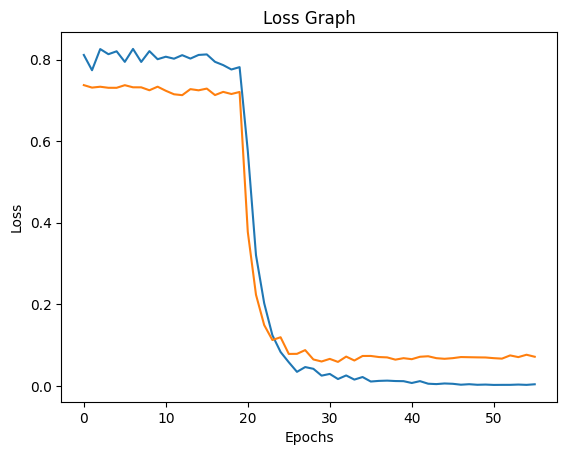

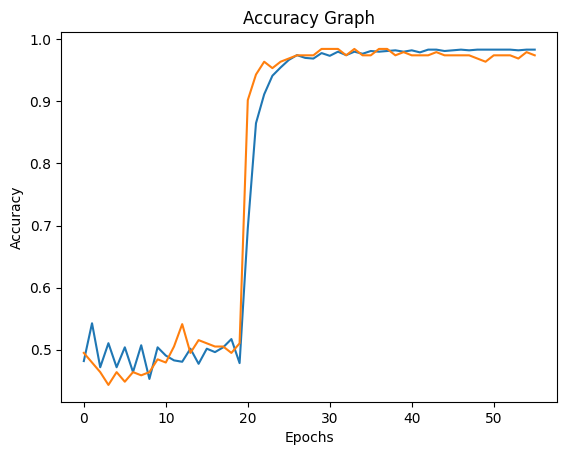

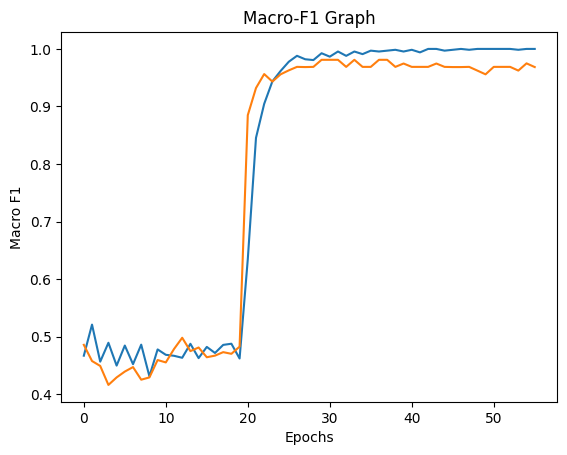

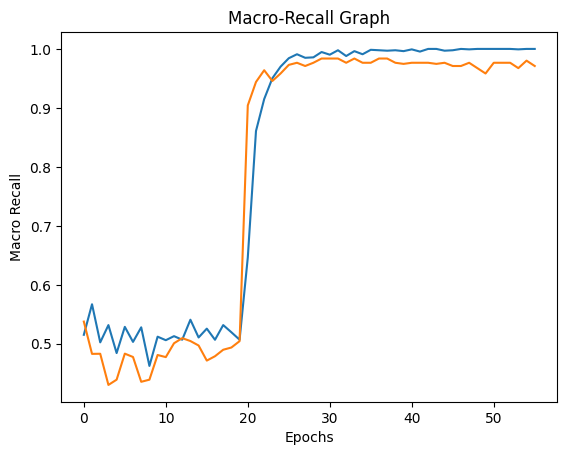

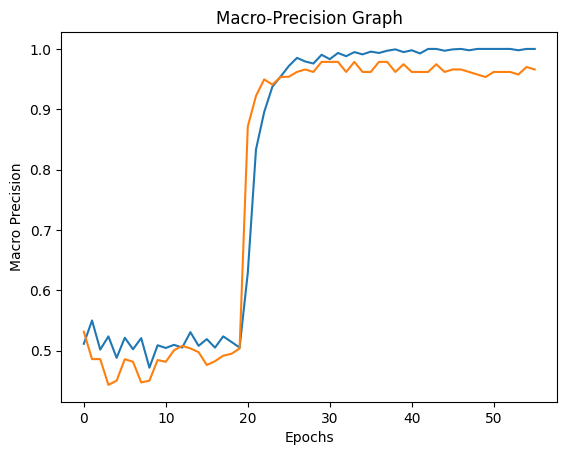

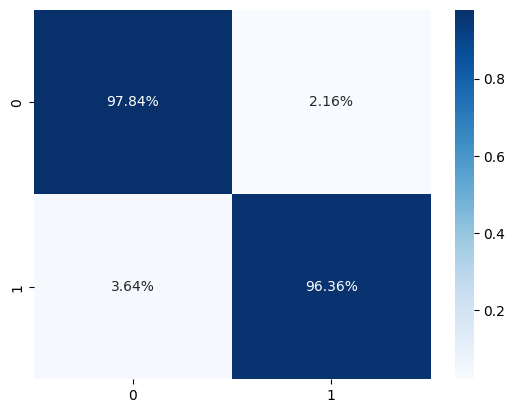

In [24]:
# train
checkpoint_dir_name = 'multitask_2classes_FPN_resnext101_dice_weightedlossadjuster_202308131522'
train_model(train_loader, val_loader, model, epochs, checkpoint_dir_name)


# save the model (only the weights)
torch.save(model.state_dict(), 'multitask_2classes_FPN_resnext101_dice_weightedlossadjuster_202308131522\model_saved.pth')


In [106]:
load_model_path = r'C:\Users\user\Downloads\Susan_project\multitask_2classes_FPN_resnext101_dice_202308121840\checkpoint-0.931-47.pth'
model.load_state_dict(torch.load(load_model_path))

<All keys matched successfully>

In [ ]:
# 0 black 149 orange 222 yellow 178 blue 75 red

Following 2 cells are for testing the style of images

In [77]:
mask = np.asarray(Image.open(r'C:\Users\user\Downloads\Susan_project\cleaned_masks\0-0722-HD367-Disc-RE.png').convert("L"))
mask_ = Image.open(r'C:\Users\user\Downloads\Susan_project\cleaned_masks\0-0722-HD367-Disc-RE.png').convert("L")
img = Image.open(r'C:\Users\user\Downloads\Susan_project\images\0-0722-HD367-Disc-RE.png').convert("RGB")
print(mask.shape)
print(mask_.size)
print(np.unique(mask.reshape(-1, 1)))

(563, 564)
(564, 563)
[  0  75 149 178 222]


In [31]:
mask = np.asarray(Image.open(r'C:\Users\user\Downloads\Susan_project\cleaned_masks\0-SNANUH0153-Optic Disc Cube 200x200-RE.Enface.png').convert("L"))
print(mask)
print(np.unique(mask.reshape(-1, 1)))

trans = transforms.Compose([transforms.Resize(256, interpolation=transforms.InterpolationMode.NEAREST_EXACT), transforms.ToTensor()])
print(torch.unique(trans(Image.open(r'C:\Users\user\Downloads\Susan_project\cleaned_masks\0-SNANUH0153-Optic Disc Cube 200x200-RE.Enface.png').convert("L"))))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[  0 149 178 222]
tensor([0.0000, 0.5843, 0.6980, 0.8706])


In [19]:
# If folder doesn't exists, create it #
fmask_dir = 'fake_mask'
if not os.path.isdir(fmask_dir):
    os.mkdir(fmask_dir)

In [27]:
# test the generated mask
#fmask_dir = 'fake_mask'
model = model.to(device)
model.eval()
with torch.no_grad():
    for item in tqdm(val_loader):
        inputs, targets = item['image'].to(device), item['mask'].to(device)
        filename = item['filename']
        
        outputs,_ = model(inputs)
        _, output_toprint = torch.max(outputs, 1)
        np_fmask = output_toprint.detach().cpu().numpy()
        #print(np_fmask)
        
        _, np_mask = torch.max(item['mask'], 1)
        np_mask = np_mask.numpy()
        
        #print(np_mask[:, 75:175, 75:175])
        
        #print(np_fmask.shape)
        for idx in range(len(np_fmask)):
            #print(fm.shape)
            
            #print(np.unique(np_fmask[idx].reshape(-1, 1)))
            #print(idx)
            #print(np.unique(np_mask[idx].reshape(-1, 1)))
            #print(np.unique(np_fmask[idx].reshape(-1, 1)))
            #print(np_fmask[idx][75:125, 75:125])
            im = Image.fromarray((np_mask[idx]*63).astype("uint8"))
            #im.show()
            new_path = os.path.join(fmask_dir, filename[idx])
            im.save(new_path)

100%|██████████| 25/25 [00:08<00:00,  2.80it/s]


In [28]:
# test the generated mask
fmask_dir = 'fake_mask'
model = model.to(device)
model.eval()
with torch.no_grad():
    for item in tqdm(val_loader):
        inputs, targets = item['image'].to(device), item['mask'].to(device)
        filename = item['filename']
        
        outputs,_ = model(inputs)
        _, output_toprint = torch.max(outputs, 1)
        np_fmask = output_toprint.detach().cpu().numpy()
        #print(np_fmask)
        
        np_mask = item['mask'].numpy()
        #print(np_mask[0], filename[0])
        
        #print(np_fmask.shape)
        for idx in range(len(np_fmask)):
            #print(fm.shape)
            
            #print(np.unique(np_fmask[idx].reshape(-1, 1)))
            im = Image.fromarray((np_fmask[idx]*63).astype("uint8"))
            #im.show()
            tmp = '-'.join(['fake', filename[idx]])
            new_path = os.path.join(fmask_dir, tmp)
            im.save(new_path)

100%|██████████| 25/25 [00:08<00:00,  3.00it/s]


In [68]:
# make prediction
def make_predictions(model, test_data):
    model.eval()
    test_labels = []
    test_preds = []
    #criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        
        for item in tqdm(test_data):
            
            test_labels.extend(item['label'].numpy())
            test_inputs, test_targets = item['image'].to(device), item['label'].to(device)
            _, test_outputs = model(test_inputs)
            #print("test:", test_outputs)
                
            _, test_pred = torch.max(test_outputs, 1)
            test_preds.extend(test_pred.detach().cpu().numpy())
            
        
        # confusion matrix of the last time
        test_cfmtx = confusion_matrix(test_labels, test_preds)
        #print(val_cfmtx.type)
        test_cfmtxn = test_cfmtx.astype('float') / test_cfmtx.sum(axis=1)[:, np.newaxis]
        sns.heatmap(test_cfmtxn, annot=True, fmt='.2%', cmap='Blues')
    
    return {
        'groundtruth':test_labels,
        'predictions':test_preds
    }



In [57]:
# create a csv file to record the wrongly predicted ones
def load_error_record(ds, predicts):
    with open('error_record.csv', 'w', newline='') as csvfile:
    
        fieldnames = ['filename', 'true_label', 'predicted_label']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
    
        for i in range(len(ds)):
            if predicts['groundtruth'][i] != predicts['predictions'][i]:
                writer.writerow({'filename': ds.load_gradcam_item(i)['filename'], 'true_label':predicts['groundtruth'][i], 'predicted_label': predicts['predictions'][i]})

    csvfile.close()

            

In [58]:
            
#grad cam
def show_gradcam(model, target_layers, desired_ds, predictions, true_labels=True):
    '''
    Parameters
    ----------
    model : 
        The model to be used.
    target_layers : 
        target layers... for resnet50 it's layer4
    use_cuda : Boolean, optional
        Whether to use cuda. The default is True.
    desired_ds : MyDataset class
        Which dataset want to use.
    true_labels : Boolean, optional
        Whether compare to true label. The default is False.

    Returns
    -------
    None.

    '''
    # can obtain RBG img and tensor and label from Mydataset function load_gradcam_item
    # take validation as example
    with GradCAM(model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available()) as cam:
        
        # save it to a new folder
        dire = "gradcam_figures"
        # If folder doesn't exists, create it ##
        if not os.path.isdir(dire):
            os.mkdir(dire)
        
    
        for i in range(len(desired_ds)):
            if true_labels:
                targets = [ClassifierOutputTarget(category) for category in np.array([desired_ds.load_gradcam_item(i)['label']])]
                #print(np.array([desired_ds.load_gradcam_item(i)['label']]))
                grayscale_cam = cam(input_tensor=desired_ds.load_gradcam_item(i)['tensor'].unsqueeze(0), targets=targets)
            else: 
                preds = [ClassifierOutputTarget(category) for category in np.array([predictions['predictions'][i]])]
                #print(desired_ds.load_gradcam_item(i)['tensor'].unsqueeze(0))
                grayscale_cam = cam(input_tensor=desired_ds.load_gradcam_item(i)['tensor'].unsqueeze(0), targets=preds)
                
            # load the crop size also
            crop_size = desired_ds.load_gradcam_item(i)['cropsize']
            
            grayscale_cam = grayscale_cam[0, :, :]
            img = transforms.CenterCrop(crop_size)(desired_ds.load_gradcam_item(i)['image'])
            img = transforms.Resize(288)(img) #288
            img = (img - np.min(img)) / (np.max(img) - np.min(img))
            visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)
            pImg = Image.fromarray(visualization, 'RGB')
            #break    
    
    
            # adjust the filename
            fn = desired_ds.load_gradcam_item(i)['filename']
            if true_labels:
                new_fn = ''.join(['true-', fn])
            else:
                # need the predictions to form the figures
                fn = ''.join([str(predictions['predictions'][i]), fn[1:]])
                new_fn = ''.join(['predicted-', fn])
            #print(new_fn)
            new_fn = os.path.join(dire, new_fn)
            #print(new_fn)
            #pImg.save(new_fn)
            
            if desired_ds.load_gradcam_item(i)['label'] != predictions['predictions'][i]:
                #print('Mismatch!',desired_ds.load_gradcam_item(i)['label'], predictions['predictions'][i])
                pImg.save(new_fn)
            #else:
                #print('Correct!',desired_ds.load_gradcam_item(i)['label'], predictions['predictions'][i])
            #break
            
    load_error_record(desired_ds, predictions)
    

In [122]:
class ClassificationModel(nn.Module):
    def __init__(self, model, load_model_path):
        super(ClassificationModel, self).__init__()
        self.model = model
        model.load_state_dict(torch.load(load_model_path))
        self.encoder = model.encoder
        #print(model.encoder.out_channels)
        #self.decoder = decoder
        self.classification_head = model.classification_head

        
    def forward(self, x):
        x1 = self.encoder(x)
        #print(x1[-1])
        #x2 = torch.flatten(x1, 1)
        x2 = self.classification_head(x1[-1])
        return x2

In [123]:
#load_model_path = r'C:\Users\user\Downloads\Susan_project\multitask_efficientnetb0_checkpoints_20230725_celoss_test\checkpoint-0.985-42.pth'
c_model = ClassificationModel(model, load_model_path)
#print(c_model.state_dict())

In [124]:
#target_layers = [model_ft.layer4[-1]]
#target_layers = [model_ft.features[-1]]
c_model = c_model.to(device)
#target_layers = [c_model.encoder._conv_head]
#target_layers = [c_model.encoder._blocks[-1]._depthwise_conv]
target_layers = [c_model.encoder.layer4[-1]]
print(target_layers)

[Bottleneck(
  (conv1): Conv2d(2048, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(2048, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
  (bn2): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(2048, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)]


100%|██████████| 25/25 [00:07<00:00,  3.43it/s]


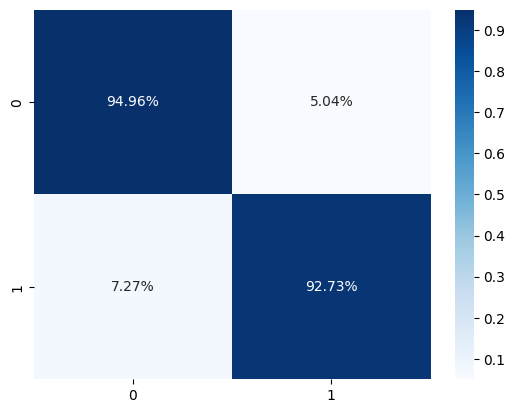

In [125]:
predictions = make_predictions(model, val_loader)

In [126]:
show_gradcam(c_model, target_layers, val_ds, predictions, true_labels=False) 

Below: for testing

In [75]:
# test images

test_img_dir = r'E:\E-GLAU ONH Cirrus En Face Images'

test_img_whole_paths = []

labels = [0, 0, 0, 0]

for path in os.listdir(test_img_dir):
    if path[0] != '.':
        #print(path)
        labels[int(path[0])] += 1
        img_p = os.path.join(test_img_dir, path)
        # check if current path is a file
        if os.path.isfile(img_p):
            #print(path)
            # store the path names
            item = {}
            item['img_path'] = img_p
            test_img_whole_paths.append(item)

In [76]:
print(len(test_img_whole_paths))
print(labels)

287
[47, 125, 107, 8]


In [85]:
new_test_ds = MyDataset(test_img_whole_paths, 'test')
new_test_loader = DataLoader(new_test_ds, batch_size=2, shuffle=False) # test

100%|██████████| 144/144 [00:09<00:00, 15.49it/s]


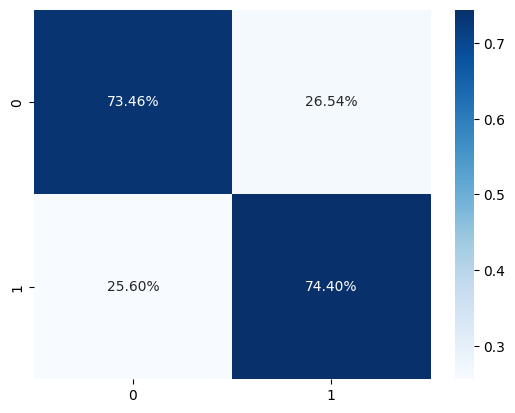

In [110]:
new_predictions = make_predictions(model, new_test_loader)

In [111]:
show_gradcam(c_model, target_layers, new_test_ds, new_predictions, true_labels=False) 

In [32]:
# test the generated mask
fmask_dir = 'fake_mask'
model = model.to(device)
model.eval()
with torch.no_grad():
    for item in tqdm(new_test_loader):
        inputs, targets = item['image'].to(device), item['mask'].to(device)
        filename = item['filename']
        
        outputs,_ = model(inputs)
        _, output_toprint = torch.max(outputs, 1)
        np_fmask = output_toprint.detach().cpu().numpy()
        #print(np_fmask)
        
        np_mask = item['mask'].numpy()
        #print(np_mask[0], filename[0])
        
        #print(np_fmask.shape)
        for idx in range(len(np_fmask)):
            #print(fm.shape)
            
            #print(np.unique(np_fmask[idx].reshape(-1, 1)))
            im = Image.fromarray((np_fmask[idx]*63).astype("uint8"))
            #im.show()
            tmp = '-'.join(['fake', filename[idx]])
            new_path = os.path.join(fmask_dir, tmp)
            im.save(new_path)

100%|██████████| 144/144 [00:11<00:00, 12.96it/s]


In [112]:
data_detail = r'C:\Users\user\Downloads\Susan_project\error_record.csv'

df = pd.read_csv(data_detail)
display(df)

,filename,true_label,predicted_label
0,2-EGLAU0163-Optic Disc Cube 200x200-RE.png,0,1
1,1-EGLAU0163-Optic Disc Cube 200x200-LE.png,1,0
2,2-EGLAU0166-Optic Disc Cube 200x200-RE.png,0,1
3,1-EGLAU0171-Optic Disc Cube 200x200-RE.png,1,0
4,1-EGLAU0172-Optic Disc Cube 200x200-LE.png,1,0
...,...,...,...
70,1-EGLAU0311-Optic Disc Cube 200x200-LE.png,1,0
71,2-EGLAU0284-Optic Disc Cube 200x200-LE.png,0,1
72,2-EGLAU0287-Optic Disc Cube 200x200-LE.png,0,1
73,2-EGLAU0290-Optic Disc Cube 200x200-LE.png,0,1


In [113]:
filename = df.loc[:, 'filename'].tolist()
true_label = df.loc[:, 'true_label'].tolist()
predicted_label = df.loc[:, 'predicted_label'].tolist()

In [114]:
# discard 2
FP = 0
FN = 0
for i in range(len(filename)):
    #print(filename[i][0])
    if int(filename[i][0]) != 2:
        if true_label[i] == 0:
            FP += 1
        else:
            FN += 1
            
print('FP', FP, FP/55)
print('FN', FN, FN/125)

FP 9 0.16363636363636364
FN 32 0.256


In [105]:
# discard 2
FP = 0
FN = 0
for i in range(len(filename)):
    #print(filename[i][0])
    #if int(filename[i][0]) != 2:
    if true_label[i] == 0:
        FP += 1
    else:
        FN += 1
            
print('FP', FP, FP/162)
print('FN', FN, FN/125)

FP 51 0.3148148148148148
FN 27 0.216


Check image distribution

In [142]:
mean = []
contrast = []
dataset_class = []

In [143]:
for img in test_img_whole_paths:
    im = Image.open(img['img_path']).convert("L")
    img_w, img_h= im.size
    img_left = 12
    img_top = 12
    img_right = img_w-12
    img_bottom = img_h-12
    im = im.crop((img_left, img_top, img_right, img_bottom))
    imin = np.min(im)
    imax = np.max(im)
    
    c = (imax - imin) / (imax + imin)
    #print(c)
    contrast.append(c)
    m = np.mean(im)
    mean.append(m)
    
    dataset_class.append('new')
    

C:\Users\user\AppData\Local\Temp\ipykernel_11624\1710156770.py:12: RuntimeWarning: overflow encountered in scalar add
  c = (imax - imin) / (imax + imin)


In [144]:
for img in img_whole_paths:
    im = Image.open(img).convert("L")
    img_w, img_h= im.size
    img_left = 12
    img_top = 12
    img_right = img_w-12
    img_bottom = img_h-12
    im = im.crop((img_left, img_top, img_right, img_bottom))
    imin = np.min(im)
    imax = np.max(im)
    
    c = (imax - imin) / (imax + imin)
    #print(c)
    contrast.append(c)
    m = np.mean(im)
    mean.append(m)
    
    dataset_class.append('old')

C:\Users\user\AppData\Local\Temp\ipykernel_11624\2430952479.py:12: RuntimeWarning: overflow encountered in scalar add
  c = (imax - imin) / (imax + imin)


In [145]:
data = {'mean': mean,
        'contrast': contrast,
        'class': dataset_class}

df = pd.DataFrame(data)

<Axes: xlabel='mean', ylabel='contrast'>

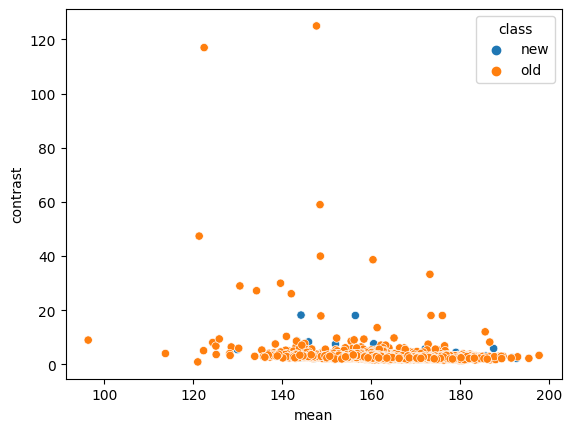

In [146]:
sns.scatterplot(data=df, x="mean", y="contrast", hue="class")